In [109]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [110]:
df = pd.read_csv('../Datasets/EDA/fake_ai_models.csv')

### EDA PROCESS

#### 1. Null Value Handling

In [111]:
# check for null values in each column.
df.isna().sum()

Company_Name                     0
Model_Name                       0
Release_Year                     0
Parameters_Billion               0
Dataset_Size_TrillionTokens      0
Training_Cost_MillionUSD       179
Benchmark_Score                  0
Model_Type                       0
Domain                           0
Country                          0
Status                           0
Last_Update_Date                 0
Comments                         0
dtype: int64

In [112]:
# Fill missing cost values with median
df['Training_Cost_MillionUSD'].fillna(df['Training_Cost_MillionUSD'].median(), inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_19620\3204078721.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Training_Cost_MillionUSD'].fillna(df['Training_Cost_MillionUSD'].median(), inplace=True)


#### 2. Cleaning incorrect data.

In [113]:
# the release year column has some inconsistencies.
df['Release_Year'].unique()

array(['20', '2024', '19', 'FY22', '18', 'FY25', '2023', '24', 'FY23',
       'FY20', '2025', '2019', '22', '2022', 'FY21', 'FY24', 'FY18',
       'FY19', '2020', '2018', '21', '25', '2021', '23'], dtype=object)

In [114]:
# Extract digits
df['Release_Year'] = df['Release_Year'].astype(str).str.extract(r'(\d{2,4})')
df['Release_Year'] = df['Release_Year'].astype(float)

# Convert 2 digit years like '22', '23', to four-digit like '2022', '2023'.
df.loc[df['Release_Year'] < 100, 'Release_Year'] += 2000

In [115]:
df['Release_Year'].unique()

array([2020., 2024., 2019., 2022., 2018., 2025., 2023., 2021.])

In [116]:
# Trim spaces and make consistent capitalization
df['Model_Type'] = df['Model_Type'].str.strip().str.title()
df['Domain'] = df['Domain'].str.strip().str.title()
df['Country'] = df['Country'].str.strip().str.title()
df['Status'] = df['Status'].str.strip().str.title()

In [117]:
# correct spelling mistakes.
df['Model_Type'] = df['Model_Type'].replace({
    'Llms': 'Llm',
    'Vision_': 'Vision',
    'Reinforcement_':'Reinforcement',
    'Multimodal_': 'Multimodal',
    'Multimodals': 'Multimodal',
    'Llm_': 'Llm',
    'Reinforcements': 'Reinforcement',
    'Visions': 'Vision',
    'Roboticss': 'Robotics',
    'Robotics_': 'Robotics',
})

In [118]:
# convert the 'Last_Update_Date' column to datetime type.
df['Last_Update_Date'] = pd.to_datetime(df['Last_Update_Date'])

#### 3. Drop Duplicate Rows

In [119]:
df.drop_duplicates(inplace = True)
df.reset_index(drop =  True, inplace = True)

#### 4. Outlier Detection

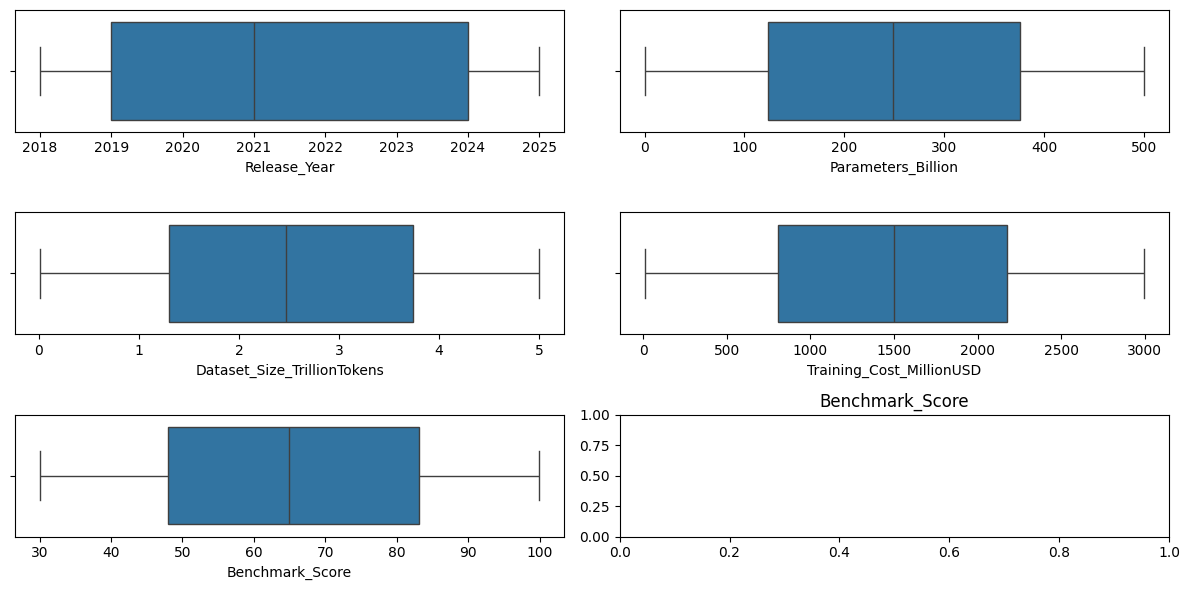

In [120]:
# it seems that there are no outliers.
fig, ax = plt.subplots(3, 2, figsize = (12, 6))
columns = iter(df.select_dtypes('float').columns)
for i in range(3):
    for j in range(2):
        try:
            col = next(columns)
            sns.boxplot(df, x = col, ax = ax[i, j])
            plt.title(col)
        except StopIteration as e:
            print(e)
plt.tight_layout()
plt.show()

#### 5. skewness

In [121]:
# it seems that the data is already well distributed.
df.select_dtypes('float').skew()

Release_Year                   0.040887
Parameters_Billion             0.004336
Dataset_Size_TrillionTokens    0.013796
Training_Cost_MillionUSD      -0.013153
Benchmark_Score               -0.008546
dtype: float64

#### 6. Feature Scaling

In [122]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_to_scale = ['Parameters_Billion', 'Dataset_Size_TrillionTokens', 'Training_Cost_MillionUSD', 'Benchmark_Score']

scaled_values = scaler.fit_transform(df[cols_to_scale])

# create new column names
new_col_names = [col + '_scaled' for col in cols_to_scale]

# create a new DataFrame of scaled values
df_scaled = pd.DataFrame(scaled_values, columns=new_col_names, index=df.index)

# join back to original dataframe
df = pd.concat([df, df_scaled], axis=1)

#### 7. Feature Engineering

In [123]:
# Model efficiency = score per billion parameters
df['Efficiency'] = df['Benchmark_Score'] / (df['Parameters_Billion'] + 1e-6)

# Training cost per parameter
df['Cost_Per_Param'] = df['Training_Cost_MillionUSD'] / (df['Parameters_Billion'] + 1e-6)

df.head()

,Company_Name,Model_Name,Release_Year,Parameters_Billion,Dataset_Size_TrillionTokens,Training_Cost_MillionUSD,Benchmark_Score,Model_Type,Domain,Country,Status,Last_Update_Date,Comments,Parameters_Billion_scaled,Dataset_Size_TrillionTokens_scaled,Training_Cost_MillionUSD_scaled,Benchmark_Score_scaled,Efficiency,Cost_Per_Param
0,Google DeepMind,Google_Model_JkeH,2020.0,146.1,2.21,1520.16,36.95,Multimodal,Computer Vision,China,Deprecated,2024-12-20,Fast enjoy happen a point here control.,-0.717427,-0.198858,0.036504,-1.383619,0.252909,10.404928
1,OpenAI,OpenAI_Model_bSBx,2024.0,45.1,4.58,281.67,33.50,Llm,Healthcare,Uk,Active,2024-11-11,Production available study that.,-1.411524,1.464107,-1.456810,-1.552634,0.742794,6.245454
2,Meta AI,Meta_Model_zLAp,2019.0,355.8,1.93,2119.68,35.62,Vision,Computer Vision,Uk,Underdevelopment,2025-06-19,Nature wind himself future sport.,0.723682,-0.395326,0.759377,-1.448775,0.100112,5.957504
3,NVIDIA,NVIDIA_Model_MQnM,2022.0,324.9,0.82,1370.92,77.36,Vision,Nlp,Uk,Underdevelopment,2025-06-25,Remain build task candidate.,0.511330,-1.174183,-0.143443,0.596064,0.238104,4.219514
4,Microsoft,Microsoft_Model_iOHI,2018.0,263.0,3.87,2785.21,64.59,Vision,Computer Vision,Uk,Deprecated,2025-07-27,Size feel no nothing huge real.,0.085938,0.965919,1.561842,-0.029537,0.245589,10.590152


#### 8. Encoding

In [132]:
cat_cols = ['Company_Name', 'Model_Type', 'Domain', 'Country', 'Status']
df_onehot = pd.get_dummies(df, columns=cat_cols, prefix=cat_cols, drop_first=False)
df = df.join(pd.get_dummies(df[cat_cols], prefix=cat_cols, drop_first=True))

In [134]:
df.info()    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Company_Name                        2000 non-null   object        
 1   Model_Name                          2000 non-null   object        
 2   Release_Year                        2000 non-null   float64       
 3   Parameters_Billion                  2000 non-null   float64       
 4   Dataset_Size_TrillionTokens         2000 non-null   float64       
 5   Training_Cost_MillionUSD            2000 non-null   float64       
 6   Benchmark_Score                     2000 non-null   float64       
 7   Model_Type                          2000 non-null   object        
 8   Domain                              2000 non-null   object        
 9   Country                             2000 non-null   object        
 10  Status                  

### Visualising

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   Company_Name                        2000 non-null   object        
 1   Model_Name                          2000 non-null   object        
 2   Release_Year                        2000 non-null   float64       
 3   Parameters_Billion                  2000 non-null   float64       
 4   Dataset_Size_TrillionTokens         2000 non-null   float64       
 5   Training_Cost_MillionUSD            2000 non-null   float64       
 6   Benchmark_Score                     2000 non-null   float64       
 7   Model_Type                          2000 non-null   object        
 8   Domain                              2000 non-null   object        
 9   Country                             2000 non-null   object        
 10  Status                  

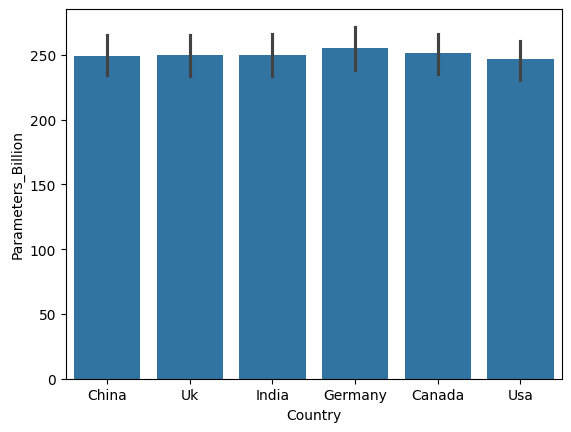

In [147]:
sns.barplot(data = df, x = 'Country', y = 'Parameters_Billion')
plt.show()